In [1]:
import torch
import torchvision
import numpy as np
import pandas as pd
import random
import os
import cv2
from PIL import Image
import seaborn as sns

import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as transforms
from torchvision import io
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = io.read_image(img_path)
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
class CustomValidationImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return 2136

    def __getitem__(self, idx):
        n = str(idx).zfill(4)
        img_path = os.path.join(self.img_dir, f"test_{n}.jpg")
        image = io.read_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [4]:
def get_circle_coordinates(img):
    mean_x, mean_y, mean_r = 98.23567973, 96.50538474, 78.20961448
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)
    rows = gray.shape[0]
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 100,
                                   param1=100, param2=25,
                                   minRadius=70, maxRadius=100)
    if circles is None:
        return (int(mean_x), int(mean_y), int(mean_r) - 5)
    else:
        return (int(circles[0][0][0]), int(circles[0][0][1]), int(circles[0][0][2]) - 5)
    
class MyCircleCropTransform:
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, img):
        x = img.squeeze().permute(2, 1, 0).numpy()
        X, Y, R = get_circle_coordinates(x)

        mask = cv2.circle(np.zeros((196, 196, 3)), (X, Y), R, (1, 1, 1), -1)
        result = mask * x
        PIL_image = Image.fromarray(np.uint8(result)).convert('RGB')
        cropped = torchvision.transforms.functional.resized_crop(PIL_image, Y - R, X - R, 2*R, 2*R, 150)
        angle = random.choice(self.angles)
        res = transforms.functional.rotate(cropped, angle)
        return torchvision.transforms.functional.pil_to_tensor(res)
    
transform = transforms.Compose(
    [MyCircleCropTransform(angles=[-90, 0, 90, 180]),
     transforms.Lambda(lambda image: torch.from_numpy(np.array(image).astype(np.float32)) / 255),
     transforms.RandomVerticalFlip(),
     transforms.RandomHorizontalFlip(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [5]:
# общая схема такая: почистить данные -> аугментация (вырезать кружок + поворот) -> обучить MobileNet v2 -> 
# -> на предсказанные на train-е значениях обучить LogisticRegression -> предсказать значения на test-е

In [6]:
rows_remove = [20, 80, 114, 451, 550, 700, 752, 760, 1243, 1428, 1580, 1961, 2136,
               2137, 2424, 2434, 2580, 2859, 2895, 3449, 3666, 5006, 5068, 5077, 5092, 
               5229, 5716, 5887, 92, 216, 330, 1916]

annotations = pd.read_csv("train.csv", index_col=0)
fixed_train_annotations = annotations.copy()
fixed_train_annotations.drop(rows_remove, inplace=True)
fixed_train_annotations.to_csv("train_fixed.csv")

In [7]:
dataset = CustomImageDataset("train_fixed.csv", "data/train/", transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=2)

submission_data = CustomValidationImageDataset("data/test/", transform)
submission_loader = DataLoader(submission_data, batch_size=4, shuffle=False)

pizza_types = pd.read_csv("classes.csv", index_col=1)

In [8]:
train_data_size = int(len(dataset) * 0.7)
test_data_size = len(dataset) - train_data_size

generator = torch.Generator().manual_seed(42)
train_data, test_data = random_split(dataset, [train_data_size, test_data_size], generator)

print("The length of train data is:", len(train_data))
print("The length of test data is:", len(test_data))

The length of train data is: 4474
The length of test data is: 1918


In [9]:
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=4, shuffle=True, num_workers=2)

/home/katsam/anaconda3/lib/python3.6/site-packages/torchvision/transforms/functional.py:165: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  img = torch.as_tensor(np.asarray(pic))


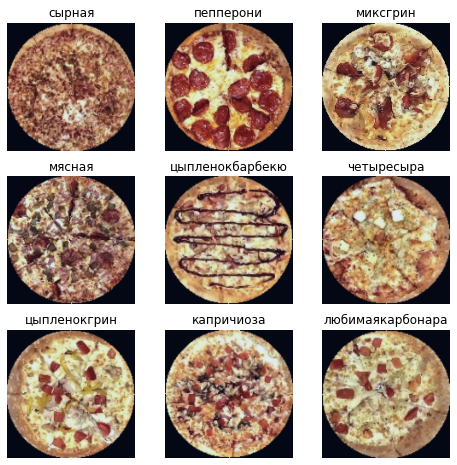

In [10]:
figure = plt.figure(figsize=(8, 8))

cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(pizza_types.iloc[label][0])
    plt.axis("off")
    plt.imshow(((img.squeeze().permute(2, 1, 0)) + 2.2) / 5)
plt.show()

In [11]:
# blocks submission answers

block_starts = [2071, 2017, 1994, 1977, 1959, 1902, 1872, 1801, 1623, 1619, 1602, 1523, 1391, 1359, 
                1358, 1354, 1338, 1310, 1309, 1293, 1293, 1263, 1202, 970, 960, 869, 857, 819, 760, 695, 
                647, 577, 547, 509, 470, 448, 425, 422, 353, 300, 263, 86, 63, 52, 18, 0]


submission_labels = [0 for i in range(2136)]
for i in range(1, 47):
    start, finish = block_starts[-i], 2136 if i == 46 else block_starts[-(i+1)]
    for j in range(start, finish):
        submission_labels[j] = i-1
        
        
submission = pd.read_csv("sample_submission.csv", index_col=0)
submission["label"] = submission_labels
submission.to_csv("blocks_submission.csv")

In [12]:
def get_submission_predictions(net, loader):
    answers = []
    X_output_vector = []
    
    with torch.no_grad():
        for images in loader:
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            answers += predicted.tolist()
            X_output_vector += outputs.data.tolist()
    return (answers, X_output_vector)

In [13]:
def get_model_accuracy(net):
    submission_predictions, _ = get_submission_predictions(net, submission_loader)

    accuracy = (np.array(submission_predictions) == np.array(submission_labels)).sum() / 2136
    print(f"Model accuracy is {round(accuracy * 100, 2)}%")
    return accuracy

In [14]:
from copy import deepcopy


def train_model(net, optimizer, max_epochs=100):
    criterion = nn.CrossEntropyLoss()
    
    best_loss = float('inf')
    best_state = None

    history_train_loss, history_test_loss = [], []
    epoch = 1
    eps = 1e-4
    while epoch <= max_epochs:
        running_train_loss = 0.0
        running_test_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        history_train_loss.append(running_train_loss / len(train_loader))
        
        with torch.no_grad():
            for i, data in enumerate(test_loader, 0):
                images, labels = data
                outputs = net(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
        history_test_loss.append(running_test_loss / len(test_loader))
        if history_test_loss[-1] <= best_loss:
            best_loss = history_test_loss[-1]
            best_state = deepcopy(net.state_dict())
        
        print(f'[{epoch}] train loss: {history_train_loss[-1]}, test loss: {history_test_loss[-1]}')
        
        if epoch % 5 == 0:
            acc = get_model_accuracy(net)
        
        epoch += 1

    net.load_state_dict(best_state)
    print('Finished Training')
    return (history_train_loss, history_test_loss, optimizer.state_dict())

In [15]:
def get_model_info(net, optimizer, max_epochs):
    net_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(net_params)

    history_train_loss, history_test_loss, optimizer_dict = train_model(net, optimizer, max_epochs)
    accuracy = get_model_accuracy(net)
    
    fig = plt.figure(figsize=(8, 6))
    epochs_number = len(history_train_loss)
    x = np.arange(1, epochs_number + 1)
    plt.title(f"Model training & test loss", fontsize=16)
    plt.plot(x, history_train_loss, label="train")
    plt.plot(x, history_test_loss, label="test")
    plt.legend(fontsize=14, shadow=0.2, loc="upper right")
    plt.xlabel("Epoch number", fontsize=14)
    plt.ylabel("Cross Entropy Loss", fontsize=14)
    
    plt.grid()
    plt.show()

    return (net_params, accuracy, history_train_loss, history_test_loss)

2282798
[1] train loss: 2.713956192468723, test loss: 2.263067478189866
[2] train loss: 2.161259218238101, test loss: 1.8947745506341258
[3] train loss: 1.9357332144401989, test loss: 1.9958673898130654
[4] train loss: 1.7173214716981626, test loss: 1.6620898151770234
[5] train loss: 1.5192952734535565, test loss: 1.5572519571209946
Model accuracy is 24.72%
[6] train loss: 1.345691552563796, test loss: 1.3223871944782635
[7] train loss: 1.1994346744273527, test loss: 1.0540780460073924
[8] train loss: 1.0915907232142432, test loss: 1.2066619926597923
[9] train loss: 1.0469875214180315, test loss: 1.030019090580754
[10] train loss: 0.9752370504607464, test loss: 0.9686010781675577
Model accuracy is 42.04%
[11] train loss: 0.8850088042645674, test loss: 0.7957109572715126
[12] train loss: 0.8569416323317992, test loss: 0.9776429292823499
[13] train loss: 0.802763012442588, test loss: 0.9862644926916497
[14] train loss: 0.8499986287093013, test loss: 0.8911889055860229
[15] train loss: 0.

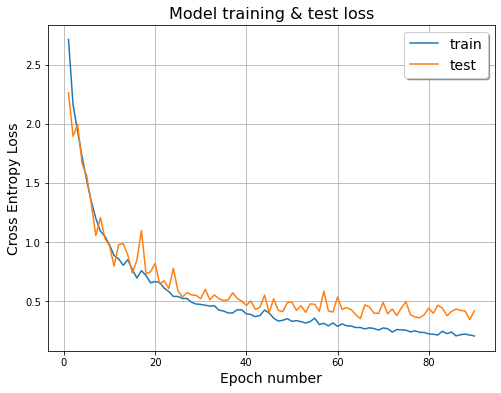

In [16]:
from torchvision import datasets, models, transforms

net = models.mobilenet_v2(pretrained=True)
    
net.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=46, bias=True)
)

optimizer = optim.Adam(net.parameters())
net_params, accuracy, history_train_loss, history_test_loss = get_model_info(net, optimizer, 90)

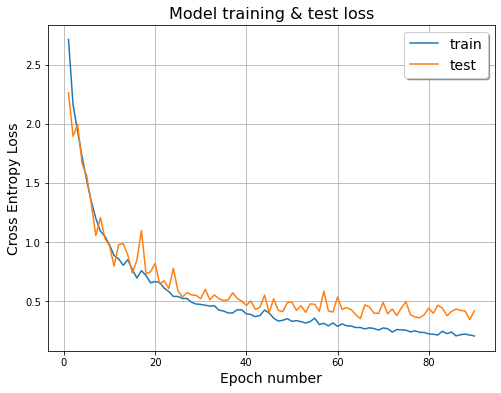

In [17]:
fig = plt.figure(figsize=(8, 6))
epochs_number = len(history_train_loss)
x = np.arange(1, epochs_number + 1)
plt.title(f"Model training & test loss", fontsize=16)
plt.plot(x, history_train_loss, label="train")
plt.plot(x, history_test_loss, label="test")
plt.legend(fontsize=14, shadow=0.2, loc="upper right")
plt.xlabel("Epoch number", fontsize=14)
plt.ylabel("Cross Entropy Loss", fontsize=14)
    
plt.grid()
plt.show()
fig.savefig("plots/mobilenet_loss.jpg", bbox_inches='tight')

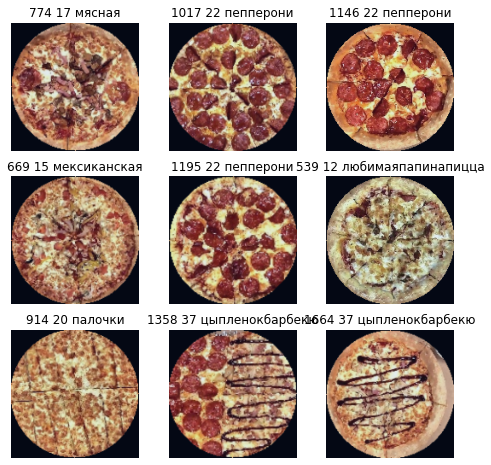

In [18]:
submission_predictions, _ = get_submission_predictions(net, submission_loader)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(submission_data), size=(1,)).item()
    img = submission_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    pred_label = submission_predictions[sample_idx]
    plt.title(f"{sample_idx} {pred_label} {pizza_types.iloc[pred_label][0]}")
    plt.axis("off")
    plt.imshow(((img.squeeze().permute(2, 1, 0)) + 2.2) / 5)
plt.show()

In [19]:
def get_train_predictions(net, loader):
    answers = []
    X_output_vector = []
    y = []
    
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            answers += predicted.tolist()
            X_output_vector += outputs.data.tolist()
            y += labels.data.tolist()
    return (answers, X_output_vector, y)

In [20]:
y_train_predicted, X_train_outputs, y_train_true = get_train_predictions(net, dataloader)

y_submission_predicted, X_submission_outputs = get_submission_predictions(net, submission_loader)
y_submission_true = submission_labels

In [21]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train_outputs)
X_submission_scaled = ss.transform(X_submission_outputs)

model = LogisticRegression(C=1.5).fit(X_train_scaled, y_train_true)
print(model.score(X_train_scaled, y_train_true), 
      accuracy_score(y_train_true, y_train_predicted))

print(model.score(X_submission_scaled, y_submission_true), 
      accuracy_score(y_submission_true, y_submission_predicted)) # 0.764

0.8347934918648311 0.7210575719649562
0.75 0.6783707865168539


/home/katsam/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [22]:
y_submission = model.predict(X_submission_scaled)

submission = pd.read_csv("sample_submission.csv", index_col=0)
submission["label"] = y_submission
submission.to_csv("mobilenet_logreg_submission.csv")
submission

,label
id,
0,0
1,3
2,0
3,0
4,0
...,...
2131,7
2132,45
2133,45


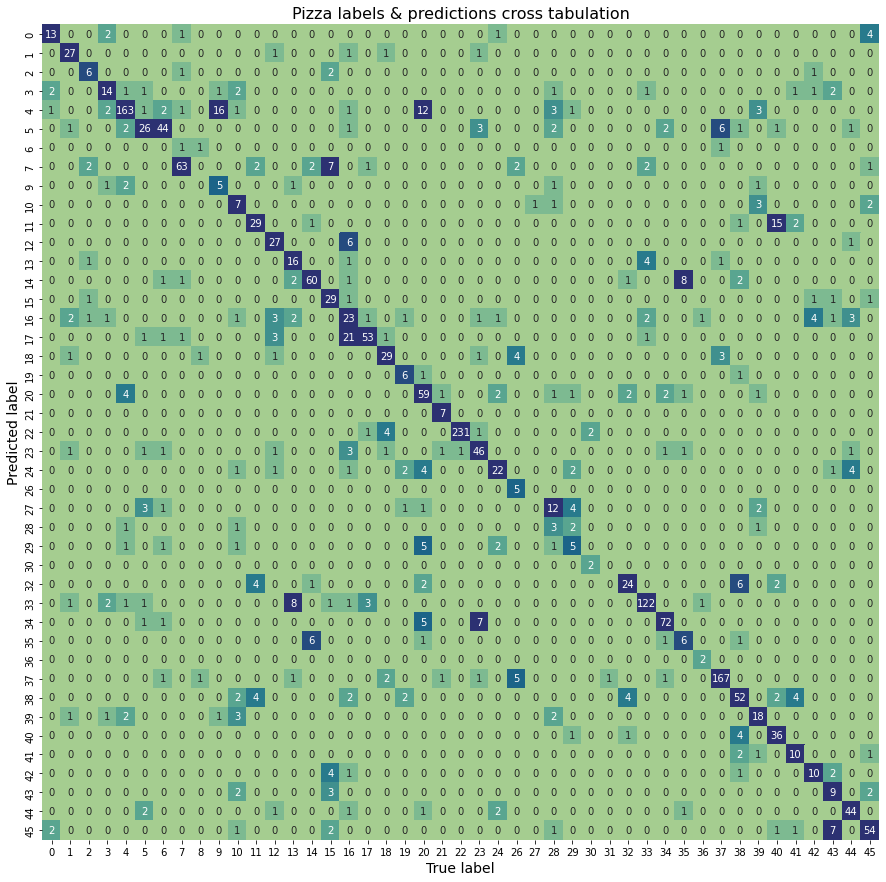

In [23]:
mobilenet_submission = pd.read_csv("mobilenet_logreg_submission.csv", index_col=0)

combine_submissions = submission.copy()
combine_submissions["label"] = y_submission
combine_submissions["true_label"] = submission_labels

labels_crosstab = pd.crosstab(index=combine_submissions['label'],
                              columns=combine_submissions['true_label'])

fig = plt.figure(figsize=(15, 15))
plt.title("Pizza labels & predictions cross tabulation", fontsize=16)
sns.heatmap(labels_crosstab, robust=True, annot=labels_crosstab, fmt='d',
            cbar=False, annot_kws={'fontsize':10}, cmap="crest")
plt.xlabel("True label", fontsize=14)
plt.ylabel("Predicted label", fontsize=14)
plt.show()
fig.savefig("plots/labels_crosstab.jpg", bbox_inches='tight')